# Training of an autoencoder using a subset of the images

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

2023-04-07 01:22:46.516531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github

In [2]:
noise_filter = True

## Reading and normalizing the images

In [3]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    file_list = [f for f in file_list if f not in noise_imgs]

AIA193_2016 = sunpy.map.Map(file_list)


AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))
AIA193_2016_matrix = np.clip(AIA193_2016_matrix, 0, 5000)

# Normalize images
min_values = AIA193_2016_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values) / rg

input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.25)

KeyboardInterrupt: 

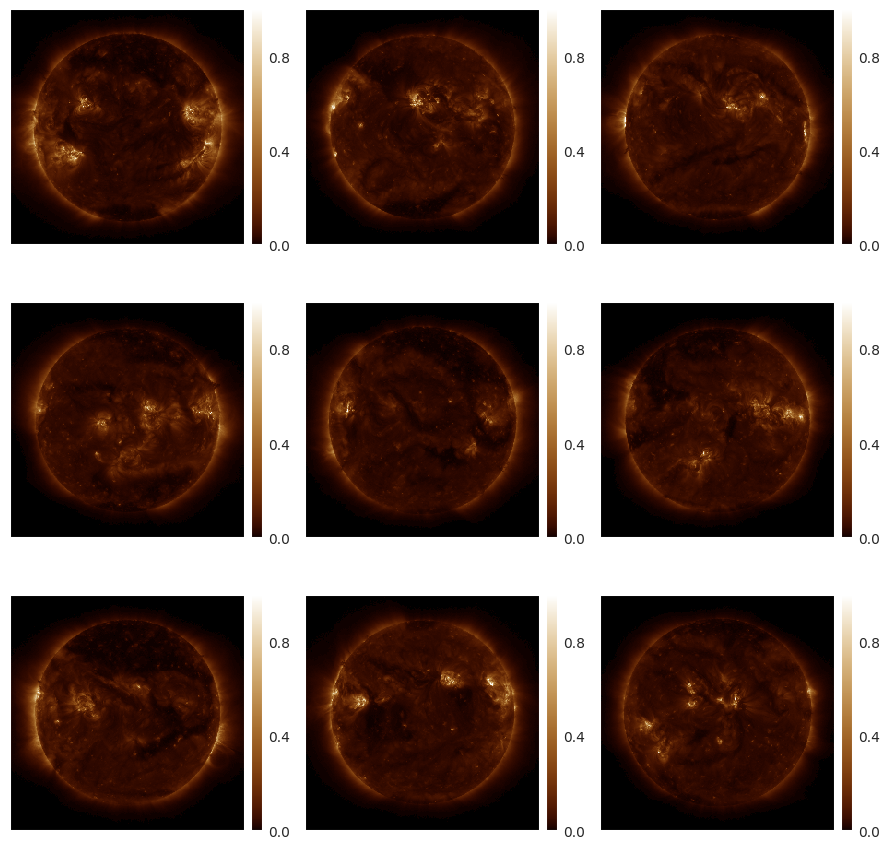

In [7]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in AIA193_2016_mnorm[:9]], cmap=aia193_colormap)

## Training the model

In [8]:
latent_size = 48
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD()
autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")

2023-04-06 18:13:39.165831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 18:13:39.183931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 18:13:39.184114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                             

In [9]:
n_epochs = 125
batch_size = 128

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/125


2023-04-06 18:13:42.872194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-06 18:13:43.933028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 13s 247ms/step - loss: 0.0044 - mae: 0.0357 - val_loss: 0.0037 - val_mae: 0.0382
Epoch 2/125
14/14 [==============================] - 1s 86ms/step - loss: 0.0035 - mae: 0.0369 - val_loss: 0.0034 - val_mae: 0.0354
Epoch 3/125
14/14 [==============================] - 1s 85ms/step - loss: 0.0029 - mae: 0.0339 - val_loss: 0.0026 - val_mae: 0.0298
Epoch 4/125
14/14 [==============================] - 1s 88ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 0.0023 - val_mae: 0.0259
Epoch 5/125
14/14 [==============================] - 1s 85ms/step - loss: 0.0021 - mae: 0.0247 - val_loss: 0.0021 - val_mae: 0.0218
Epoch 6/125
14/14 [==============================] - 1s 87ms/step - loss: 0.0020 - mae: 0.0215 - val_loss: 0.0020 - val_mae: 0.0221
Epoch 7/125
14/14 [==============================] - 1s 88ms/step - loss: 0.0019 - mae: 0.0203 - val_loss: 0.0019 - val_mae: 0.0208
Epoch 8/125
14/14 [==============================] - 1s 86ms/step - loss: 0.0018 - mae

## Evaluating the model

20/20 [==============================] - 1s 22ms/step - loss: 7.0314e-04 - mae: 0.0115


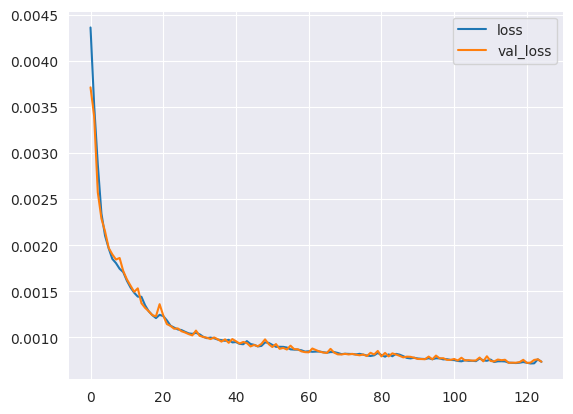

In [10]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 160ms/step


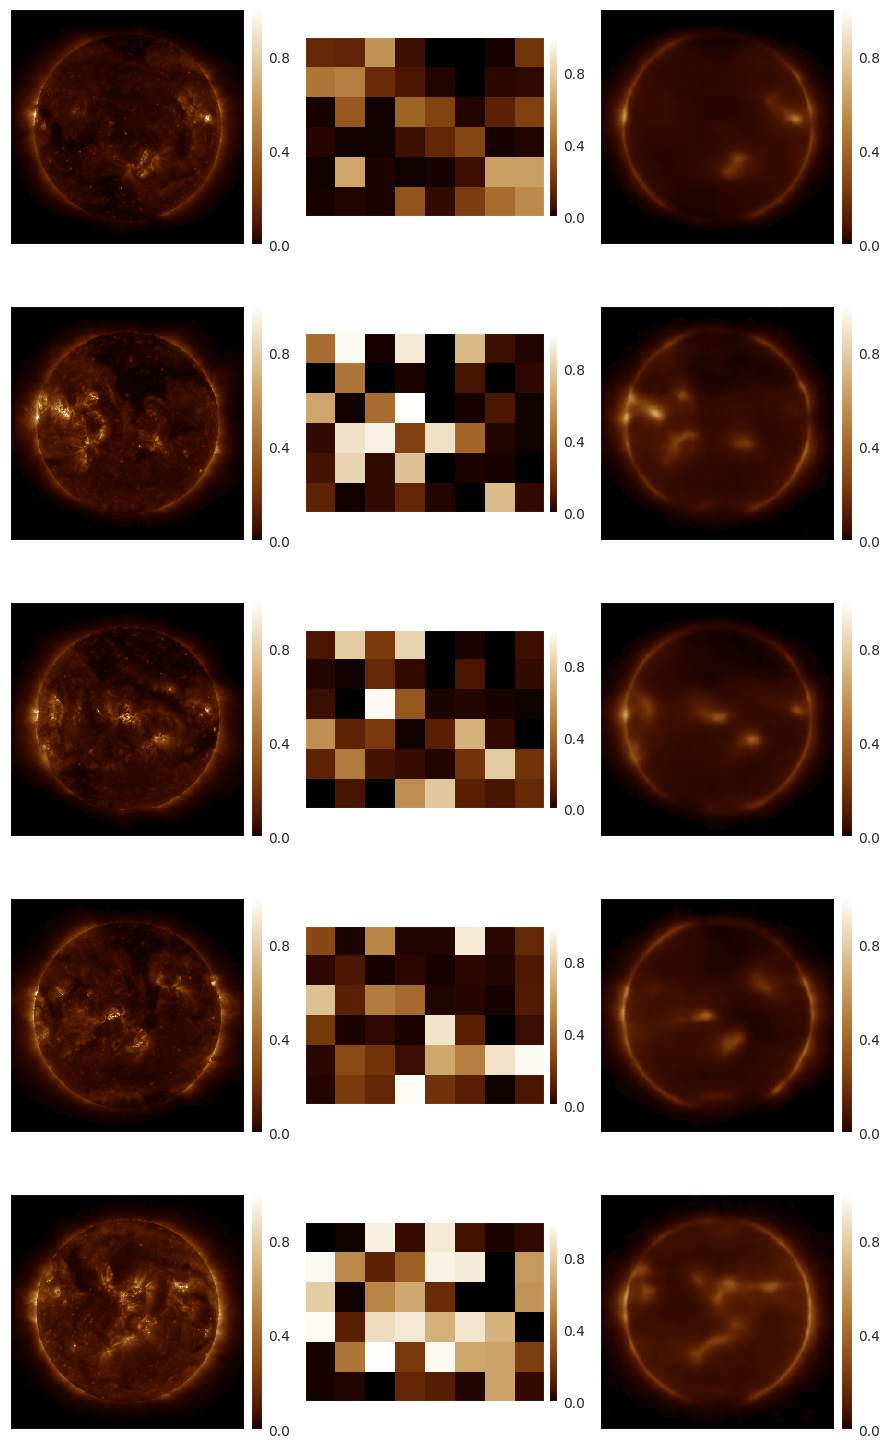

In [11]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

1/1 [==============================] - 0s 15ms/step


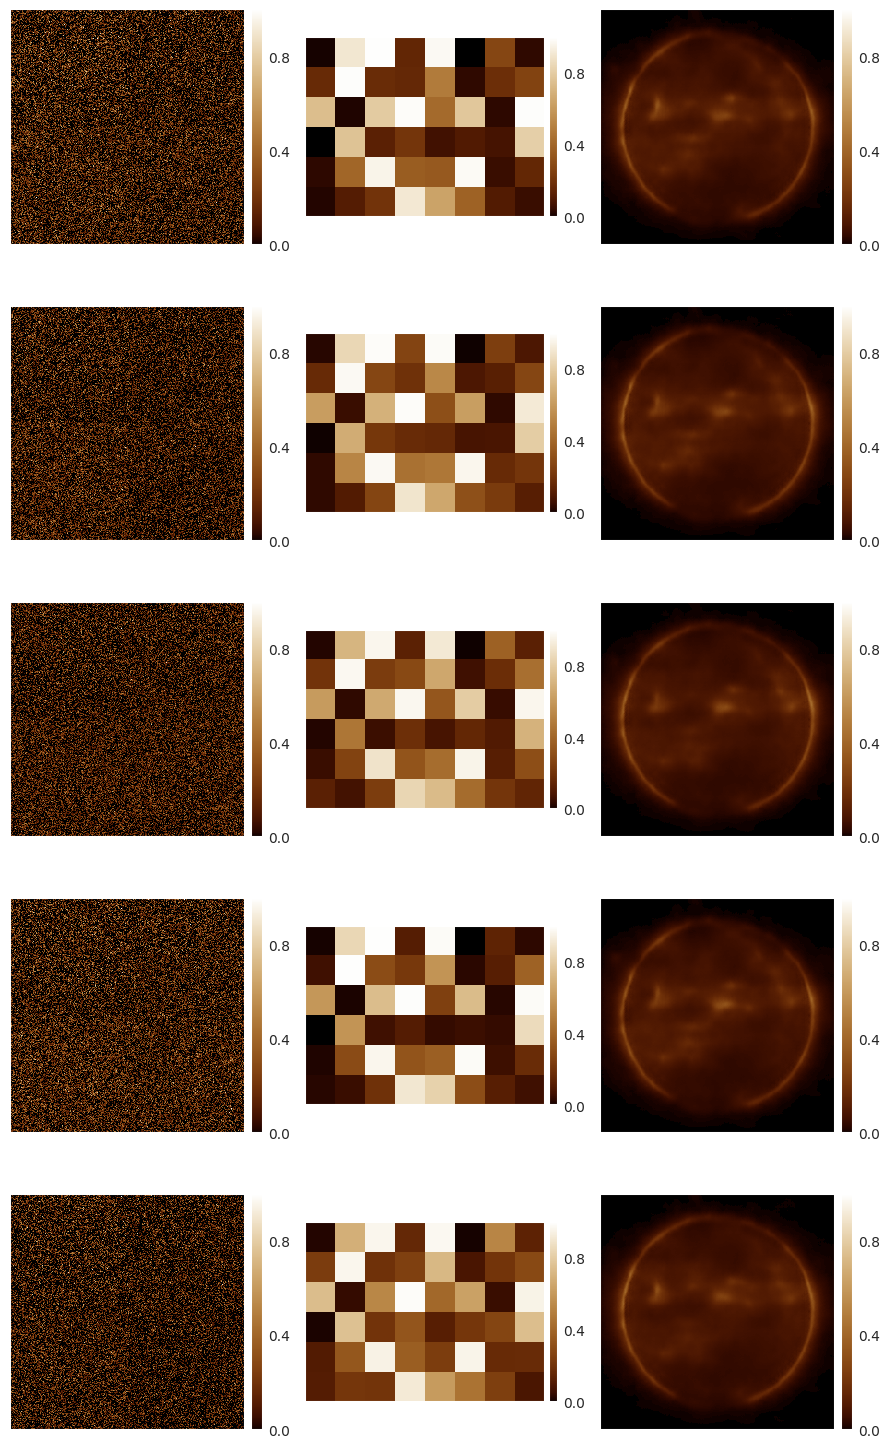

In [12]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

noisy_file_list = [f for f in file_list if f in noise_imgs]

AIA193_2016_noise = sunpy.map.Map(noisy_file_list)
AIA193_2016_matrix_noise = np.array(list(d.data for d in AIA193_2016_noise))

# Normalize images
AIA193_2016_matrix_noise = np.clip(AIA193_2016_matrix_noise, 0, 5000)
min_values = AIA193_2016_matrix_noise.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix_noise.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm_noise = (AIA193_2016_matrix_noise-min_values) / rg

idx = np.random.permutation(len(noisy_file_list))[:5]

example = AIA193_2016_mnorm_noise[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

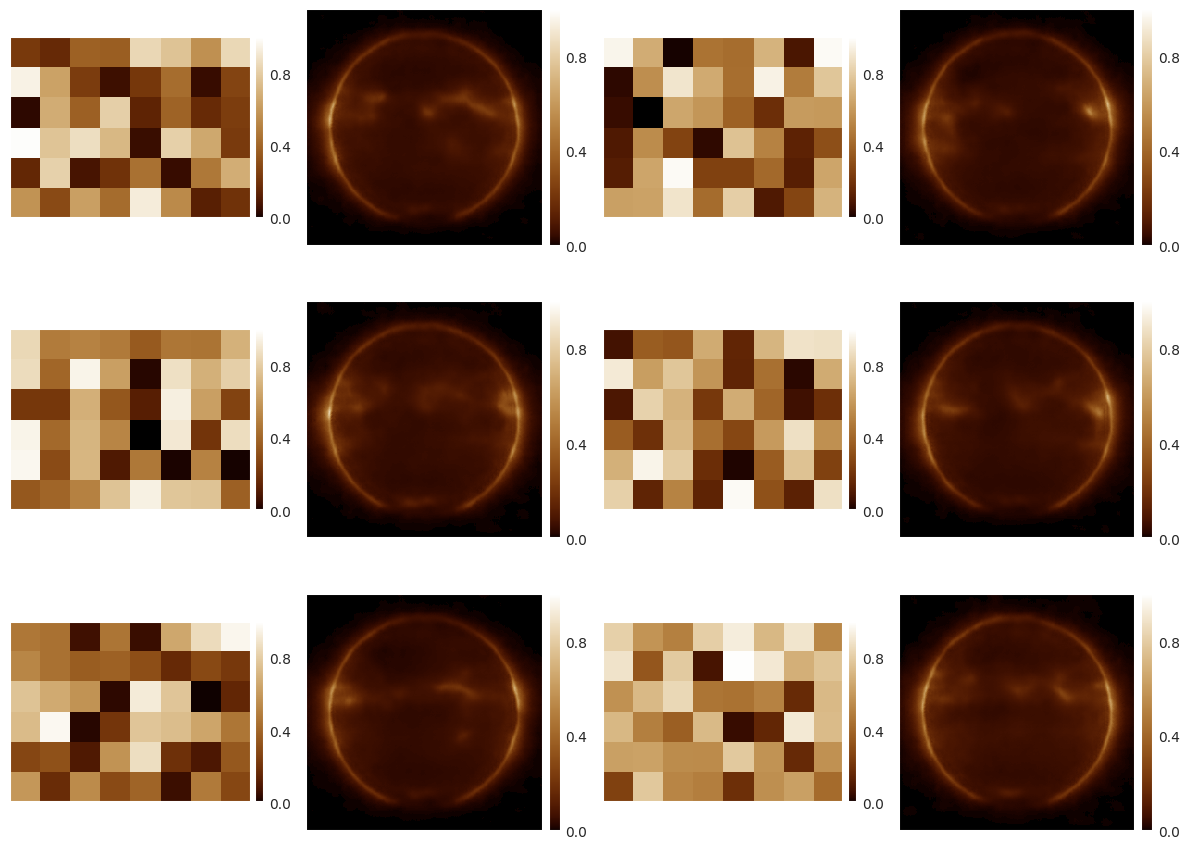

In [14]:
code = np.random.uniform(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,8]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)